# Speech Enhancement — Inference Demo
## CRN v2 vs DPT v2 | Review Panel Demonstration

**Team:** Krishnasinh Jadeja (22BLC1211) · Kirtan Sondagar (22BLC1228) · Prabhu Kalyan Panda (22BLC1213)  
**Guide:** Dr. Praveen Jaraut — VIT Chennai

This notebook runs inference using the downloaded best checkpoints:
- `crn_output/crn_v2_best.pth` — CRN Baseline (1.81M params)
- `dpt_output/dpt_v2_best.pth` — Dual-Path Transformer (0.90M params)

For each audio sample you will see:
1. **Noisy input** spectrogram + audio player
2. **CRN enhanced** spectrogram + audio player + metrics
3. **DPT enhanced** spectrogram + audio player + metrics

## Cell 1 — Imports & Setup

In [1]:
import os, glob, warnings, urllib.request
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, Audio, HTML

# ── optional metrics ──
try:
    from pesq import pesq as pesq_metric
    from pystoi import stoi as stoi_metric
    HAS_METRICS = True
except ImportError:
    HAS_METRICS = False
    print("⚠  pesq / pystoi not installed — metrics will be skipped.")
    print("   Run:  pip install pesq==0.0.4 pystoi")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device : {device}")
print(f"Metrics: {'✅ pesq + pystoi' if HAS_METRICS else '❌ not available'}")

# STFT config — must match training
N_FFT      = 512
HOP_LENGTH = 256
N_FREQ     = N_FFT // 2 + 1   # 257
SR         = 16000
MAX_LEN    = 48000             # 3 s

WINDOW = torch.hann_window(N_FFT)
print(f"STFT   : n_fft={N_FFT}, hop={HOP_LENGTH}, freq={N_FREQ}, sr={SR}")


Device : cpu
Metrics: ✅ pesq + pystoi
STFT   : n_fft=512, hop=256, freq=257, sr=16000


## Cell 2 — Model Architecture Definitions
Exact same classes used during training — do not change.

In [2]:
# ══════════════════════════════════════════════════════════════
# CRN: Conv-Recurrent Network  (1,811,009 params)
# CNN Encoder (stride-2 on freq) → per-freq LSTM → CNN Decoder
# ══════════════════════════════════════════════════════════════
class CRNBaseline(nn.Module):
    def __init__(self, n_freq=257):
        super().__init__()
        self.n_freq = n_freq
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=(2,1), padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=(2,1), padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=(2,1), padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.lstm = nn.LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.1)
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=(2,1), padding=1, output_padding=(1,0)),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=(2,1), padding=1, output_padding=(1,0)),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=(2,1), padding=1, output_padding=(1,0)),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True))
        self.mask_conv = nn.Sequential(nn.Conv2d(32, 1, 1), nn.Sigmoid())

    def forward(self, x):
        B, _, F_orig, T_orig = x.shape
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        B2, C, Fenc, T = e3.shape
        lstm_in = e3.permute(0,2,3,1).reshape(B2*Fenc, T, C)
        lstm_out, _ = self.lstm(lstm_in)
        h = lstm_out.reshape(B2, Fenc, T, C).permute(0,3,1,2)
        d3 = self.dec3(h)
        d2 = self.dec2(d3)
        d1 = self.dec1(d2)
        if d1.shape[2] != F_orig:
            d1 = F.interpolate(d1, size=(F_orig, T_orig), mode='bilinear', align_corners=False)
        return self.mask_conv(d1).squeeze(1)


# ══════════════════════════════════════════════════════════════
# DPT: Dual-Path Transformer  (904,705 params)
# CNN Encoder → 2×DualPathBlock (freq-attn + time-attn) → CNN Decoder
# ══════════════════════════════════════════════════════════════
class DualPathBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_ff, dropout):
        super().__init__()
        self.freq_transformer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_ff, dropout, batch_first=True, norm_first=True)
        self.time_transformer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_ff, dropout, batch_first=True, norm_first=True)

    def forward(self, x):
        B, C, Fr, T = x.shape
        x_f = x.permute(0,3,2,1).reshape(B*T, Fr, C)
        x_f = self.freq_transformer(x_f)
        x   = x_f.reshape(B, T, Fr, C).permute(0,3,2,1)
        x_t = x.permute(0,2,3,1).reshape(B*Fr, T, C)
        x_t = self.time_transformer(x_t)
        return x_t.reshape(B, Fr, T, C).permute(0,3,1,2)


class DPTSTFTEnhancer(nn.Module):
    def __init__(self, n_freq=257, d_model=128, nhead=4, num_dp_blocks=2,
                 dim_ff=512, dropout=0.1):
        super().__init__()
        self.n_freq = n_freq
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=(2,1), padding=1),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, d_model, 3, stride=(2,1), padding=1),
            nn.BatchNorm2d(d_model), nn.ReLU(inplace=True))
        self.dp_blocks = nn.ModuleList([
            DualPathBlock(d_model, nhead, dim_ff, dropout)
            for _ in range(num_dp_blocks)])
        self.decoder = nn.Sequential(
            nn.Conv2d(d_model, 64, 3, 1, 1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1), nn.Sigmoid())

    def forward(self, x):
        B, _, F_orig, T_orig = x.shape
        h = self.encoder(x)
        skip = h
        for block in self.dp_blocks:
            h = block(h)
        h = h + skip
        h = F.interpolate(h, size=(F_orig, T_orig), mode='bilinear', align_corners=False)
        return self.decoder(h).squeeze(1)


print("✅ CRNBaseline and DPTSTFTEnhancer defined")

✅ CRNBaseline and DPTSTFTEnhancer defined


## Cell 3 — Load Checkpoints
Loads `crn_output/crn_v2_best.pth` and `dpt_output/dpt_v2_best.pth` into their respective model classes.

In [3]:
CRN_CKPT = 'crn_output/crn_v2_best.pth'
DPT_CKPT = 'dpt_output/dpt_v2_best.pth'

def load_model(ModelClass, ckpt_path, **kwargs):
    model = ModelClass(**kwargs).to(device)
    ckpt  = torch.load(ckpt_path, map_location=device, weights_only=False)
    # checkpoints may be raw state_dict or wrapped under various keys
    if isinstance(ckpt, dict):
        state = ckpt.get('model_state_dict', ckpt.get('model', ckpt))
    else:
        state = ckpt
    model.load_state_dict(state)
    model.eval()
    epoch    = ckpt.get('epoch', '?')    if isinstance(ckpt, dict) else '?'
    val_loss = ckpt.get('val_loss', '?') if isinstance(ckpt, dict) else '?'
    n = sum(p.numel() for p in model.parameters())
    print(f"  ✅ {ModelClass.__name__:20s} | {n:>10,} params | epoch {epoch} | val_loss {val_loss:.4f} | {ckpt_path}")
    return model

print("Loading models …")
crn_model = load_model(CRNBaseline,     CRN_CKPT, n_freq=N_FREQ)
dpt_model = load_model(DPTSTFTEnhancer, DPT_CKPT, n_freq=N_FREQ)


Loading models …


  ✅ CRNBaseline          |  1,811,009 params | epoch 30 | val_loss 0.0534 | crn_output/crn_v2_best.pth
  ✅ DPTSTFTEnhancer      |    904,705 params | epoch 29 | val_loss 0.0513 | dpt_output/dpt_v2_best.pth


## Cell 4 — Audio Input
**Option A (specific file):** Set `NOISY_WAV` / `CLEAN_WAV` to explicit paths for a particular sample.

**Option B (auto, default):** Leave both as `None` — the first file from `data/test/` + `data/y_test/` is used automatically. Change `index=` in `pick_sample_pair()` to try different samples (0–104).


In [4]:
# ── CONFIGURE HERE ────────────────────────────────────────────
NOISY_WAV = None   # set to a specific path, or leave None to auto-pick from data/
CLEAN_WAV = None   # set to a specific path, or leave None to auto-pick from data/
# ─────────────────────────────────────────────────────────────

NOISY_DIR = r'data\test'    # 105 noisy WAVs
CLEAN_DIR = r'data\y_test'  # 105 matching clean WAVs

def pick_sample_pair(noisy_dir=NOISY_DIR, clean_dir=CLEAN_DIR, index=0):
    """Pick file pair at 'index' from the local dataset sample folders."""
    noisy_files = sorted(glob.glob(os.path.join(noisy_dir, '*.wav')))
    if not noisy_files:
        raise FileNotFoundError(f"No WAV files found in: {noisy_dir}")
    noisy = noisy_files[index % len(noisy_files)]
    fname = os.path.basename(noisy)
    clean = os.path.join(clean_dir, fname)
    if not os.path.exists(clean):
        clean = None
        print(f"  ⚠  No matching clean file found for {fname} — metrics vs clean unavailable")
    return noisy, clean

if NOISY_WAV is None:
    print(f"No path set — picking sample from local dataset ({NOISY_DIR}) …")
    NOISY_WAV, CLEAN_WAV = pick_sample_pair(index=0)
    print(f"  Noisy : {NOISY_WAV}")
    print(f"  Clean : {CLEAN_WAV}")
else:
    print(f"Using provided files:\n  Noisy: {NOISY_WAV}\n  Clean: {CLEAN_WAV}")


No path set — picking sample from local dataset (data\test) …
  Noisy : data\test\1034-121119-0049.wav
  Clean : data\y_test\1034-121119-0049.wav


## Cell 5 — Load & Preprocess Audio

In [5]:
import soundfile as sf

def load_wav(path, max_len=MAX_LEN, sr=SR):
    """Load a WAV with soundfile (no FFmpeg dependency), resample if needed."""
    data, orig_sr = sf.read(path, dtype='float32')
    if data.ndim > 1:
        data = data[:, 0]          # take first channel (mono)
    wav = torch.from_numpy(data)
    if orig_sr != sr:
        wav = torchaudio.functional.resample(wav, orig_sr, sr)
    # Crop / pad to MAX_LEN
    if wav.shape[0] >= max_len:
        wav = wav[:max_len]
    else:
        wav = F.pad(wav, (0, max_len - wav.shape[0]))
    return wav  # (MAX_LEN,)


def wav_to_stft(wav):
    """Returns mag (N_FREQ, T), phase (N_FREQ, T), complex stft."""
    stft = torch.stft(wav, N_FFT, HOP_LENGTH, window=WINDOW, return_complex=True)
    return stft.abs(), torch.angle(stft), stft


# Load audio
noisy_wav = load_wav(NOISY_WAV)
clean_wav = load_wav(CLEAN_WAV) if CLEAN_WAV else None

noisy_mag, noisy_phase, noisy_stft = wav_to_stft(noisy_wav)
clean_mag = wav_to_stft(clean_wav)[0] if clean_wav is not None else None

print(f"Noisy WAV : {noisy_wav.shape}  |  duration = {len(noisy_wav)/SR:.2f}s")
print(f"STFT shape: {noisy_mag.shape}  (freq × time)")
if clean_wav is not None:
    print(f"Clean WAV : {clean_wav.shape}  ✅ metrics will be computed")
else:
    print("Clean WAV : None — enhancement quality shown visually only")


Noisy WAV : torch.Size([48000])  |  duration = 3.00s
STFT shape: torch.Size([257, 188])  (freq × time)
Clean WAV : torch.Size([48000])  ✅ metrics will be computed


## Cell 6 — Run Inference (Noisy Baseline, CRN, DPT)

In [6]:
def enhance(model, noisy_mag, noisy_phase):
    """Run the model on a single noisy STFT magnitude and reconstruct the waveform."""
    inp   = torch.log1p(noisy_mag).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,257,T)
    with torch.no_grad():
        mask = model(inp).squeeze(0).cpu()                                 # (257,T)
    enhanced_mag  = mask * noisy_mag
    enhanced_stft = enhanced_mag * torch.exp(1j * noisy_phase)
    enhanced_wav  = torch.istft(enhanced_stft, N_FFT, HOP_LENGTH, window=WINDOW,
                                length=MAX_LEN)
    return enhanced_wav, mask, enhanced_mag


def compute_metrics(ref_wav, est_wav, sr=SR):
    if not HAS_METRICS or ref_wav is None:
        return {}
    r = ref_wav.numpy().astype(np.float32)
    e = est_wav.numpy().astype(np.float32)
    # normalise to prevent clipping artefacts in pesq
    r = r / (np.abs(r).max() + 1e-8)
    e = e / (np.abs(e).max() + 1e-8)
    try:
        pesq_score = pesq_metric(sr, r, e, 'wb')
    except Exception:
        pesq_score = float('nan')
    stoi_score = stoi_metric(r, e, sr, extended=False)
    # SI-SDR
    r_zm = r - r.mean(); e_zm = e - e.mean()
    alpha = np.dot(e_zm, r_zm) / (np.dot(r_zm, r_zm) + 1e-8)
    proj  = alpha * r_zm
    noise = e_zm - proj
    sisdr = 10 * np.log10((proj**2).sum() / ((noise**2).sum() + 1e-8))
    return {'PESQ': pesq_score, 'STOI': stoi_score, 'SI-SDR': sisdr}


# ── Noisy baseline (no model) ──
noisy_metrics = compute_metrics(clean_wav, noisy_wav) if clean_wav is not None else {}

# ── CRN inference ──
crn_wav, crn_mask, crn_mag = enhance(crn_model, noisy_mag, noisy_phase)
crn_metrics = compute_metrics(clean_wav, crn_wav)

# ── DPT inference ──
dpt_wav, dpt_mask, dpt_mag = enhance(dpt_model, noisy_mag, noisy_phase)
dpt_metrics = compute_metrics(clean_wav, dpt_wav)

print("=" * 52)
print(f"{'Metric':<10}  {'Noisy':>8}  {'CRN v2':>8}  {'DPT v2':>8}")
print("-" * 52)
for met in ['PESQ', 'STOI', 'SI-SDR']:
    n  = f"{noisy_metrics.get(met, float('nan')):8.3f}" if noisy_metrics else "      N/A"
    c  = f"{crn_metrics.get(met, float('nan')):8.3f}"   if crn_metrics   else "      N/A"
    d  = f"{dpt_metrics.get(met, float('nan')):8.3f}"   if dpt_metrics   else "      N/A"
    print(f"{met:<10}  {n}  {c}  {d}")
print("=" * 52)

Metric         Noisy    CRN v2    DPT v2
----------------------------------------------------
PESQ           1.114     1.771     1.751
STOI           0.684     0.756     0.761
SI-SDR         4.447    10.334    10.679


## Cell 6b — Resource & Latency Profiling
Measures inference time, peak RAM, parameter count, and checkpoint size for both models.
Relevant to **Slide 11 (Efficiency Analysis)** of the review presentation.


In [ ]:
import time, tracemalloc

# ── Configuration ─────────────────────────────────────────────
N_WARMUP  = 3      # warm-up passes (discard timing — stabilises caches)
N_RUNS    = 30     # timed passes for a stable average
TARGET_MS = 15.0   # project latency target from project spec
# ──────────────────────────────────────────────────────────────

inp = torch.log1p(noisy_mag).unsqueeze(0).unsqueeze(0).to(device)  # shared input

def time_model(model, x, n_warmup=N_WARMUP, n_runs=N_RUNS):
    """Return (mean_ms, std_ms) over n_runs inference passes."""
    model.eval()
    for _ in range(n_warmup):
        with torch.no_grad(): model(x)
    times = []
    for _ in range(n_runs):
        t0 = time.perf_counter()
        with torch.no_grad(): model(x)
        times.append((time.perf_counter() - t0) * 1000)
    return float(np.mean(times)), float(np.std(times))

def peak_ram_mb(model, x):
    """Measure peak heap increase during one CPU forward pass (MiB)."""
    model_cpu = model.cpu(); x_cpu = x.cpu()
    tracemalloc.start()
    with torch.no_grad(): model_cpu(x_cpu)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    model.to(device)          # move back
    return peak / 1024 / 1024

def ckpt_mb(path):
    return os.path.getsize(path) / 1024 / 1024

# ── Run measurements ──────────────────────────────────────────
print(f"Timing {N_RUNS} passes (+ {N_WARMUP} warm-up) on {device} ...")
crn_t, crn_ts = time_model(crn_model, inp)
dpt_t, dpt_ts = time_model(dpt_model, inp)

print("Measuring peak RAM usage (CPU forward pass) ...")
crn_ram = peak_ram_mb(crn_model, inp)
dpt_ram = peak_ram_mb(dpt_model, inp)

crn_params = sum(p.numel() for p in crn_model.parameters())
dpt_params = sum(p.numel() for p in dpt_model.parameters())

# ── Summary table ─────────────────────────────────────────────
W = 26
print("\n" + "=" * (W * 3 + 2))
print(f"{'Metric':<{W}}  {'CRN v2 (Baseline)':>{W}}  {'DPT v2 (Proposed)':>{W}}")
print("-" * (W * 3 + 2))
rows = [
    ("Parameters",         f"{crn_params/1e6:.3f} M",                      f"{dpt_params/1e6:.3f} M"),
    ("Checkpoint size",    f"{ckpt_mb(CRN_CKPT):.2f} MB",                  f"{ckpt_mb(DPT_CKPT):.2f} MB"),
    ("Inference time",     f"{crn_t:.2f} +/- {crn_ts:.2f} ms",             f"{dpt_t:.2f} +/- {dpt_ts:.2f} ms"),
    ("Peak RAM (fwd)",     f"{crn_ram:.2f} MB",                             f"{dpt_ram:.2f} MB"),
    ("Latency target",     f"{'PASS' if crn_t < TARGET_MS else 'FAIL'} (< {TARGET_MS} ms)", f"{'PASS' if dpt_t < TARGET_MS else 'FAIL'} (< {TARGET_MS} ms)"),
    ("Params <= 1M goal",  f"{'NO (over)':}  (goal: <1M)",                 f"{'YES':}  (goal: <1M)"),
]
for label, crn_val, dpt_val in rows:
    print(f"{label:<{W}}  {crn_val:>{W}}  {dpt_val:>{W}}")
print("=" * (W * 3 + 2))
print(f"\nDPT is {crn_params/dpt_params:.2f}x smaller and "
      f"{'faster' if dpt_t < crn_t else 'slower'} "
      f"({abs(crn_t-dpt_t):.2f} ms {'speedup' if dpt_t < crn_t else 'overhead'} vs CRN).")

# ── Bar chart ─────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(14, 5), constrained_layout=True)
fig.patch.set_facecolor('#1a1a2e')

categories = ['CRN v2\n(Baseline)', 'DPT v2\n(Proposed)']
colors     = ['#e74c3c', '#2ecc71']

# Left: parameters
axes[0].bar(categories, [crn_params/1e6, dpt_params/1e6], color=colors, width=0.5, edgecolor='#333')
axes[0].axhline(1.0, color='#f1c40f', linestyle='--', linewidth=1.5, label='1M goal')
axes[0].set_title('Parameters (M)', color='white', fontweight='bold')
axes[0].legend(fontsize=9, labelcolor='white', facecolor='#16213e')
for i, v in enumerate([crn_params/1e6, dpt_params/1e6]):
    axes[0].text(i, v + 0.03, f'{v:.3f}M', ha='center', color='white', fontweight='bold')

# Middle: inference time
axes[1].bar(categories, [crn_t, dpt_t], color=colors, width=0.5, edgecolor='#333',
            yerr=[crn_ts, dpt_ts], capsize=6, error_kw=dict(ecolor='#aaa', lw=1.5))
axes[1].axhline(TARGET_MS, color='#f1c40f', linestyle='--', linewidth=1.5, label=f'{TARGET_MS} ms target')
axes[1].set_title('Inference Time (ms)', color='white', fontweight='bold')
axes[1].legend(fontsize=9, labelcolor='white', facecolor='#16213e')
for i, v in enumerate([crn_t, dpt_t]):
    axes[1].text(i, v + 0.3, f'{v:.1f}ms', ha='center', color='white', fontweight='bold')

# Right: peak RAM
axes[2].bar(categories, [crn_ram, dpt_ram], color=colors, width=0.5, edgecolor='#333')
axes[2].set_title('Peak RAM — fwd pass (MB)', color='white', fontweight='bold')
for i, v in enumerate([crn_ram, dpt_ram]):
    axes[2].text(i, v + 0.3, f'{v:.1f}MB', ha='center', color='white', fontweight='bold')

for ax in axes:
    ax.set_facecolor('#16213e')
    for sp in ax.spines.values(): sp.set_edgecolor('#444')
    ax.tick_params(colors='#aaa'); ax.yaxis.set_tick_params(labelcolor='#aaa')
    ax.set_xticklabels(categories, color='white')
    ax.grid(axis='y', color='#333', linewidth=0.7); ax.set_axisbelow(True)

fig.suptitle('Efficiency Comparison — CRN vs DPT', color='white', fontsize=15, fontweight='bold')
plt.savefig('inference_efficiency.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()
print("Saved: inference_efficiency.png")


## Cell 7 — Spectrogram Comparison (Noisy → CRN → DPT → Clean)

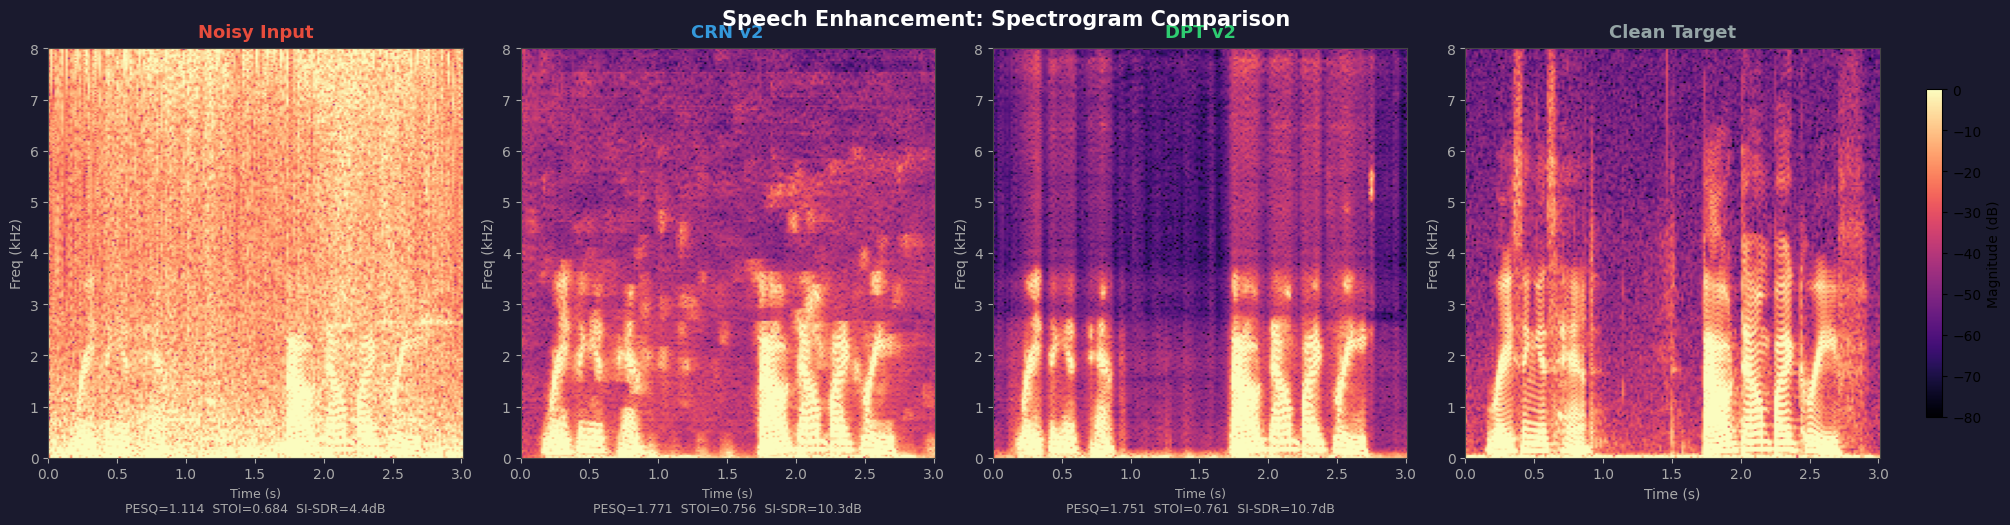

Saved: inference_comparison.png


In [7]:
def mag_to_db(mag, ref=1.0, amin=1e-5):
    return 20 * np.log10(np.maximum(mag, amin) / ref)

def plot_spec(ax, mag_tensor, title, sr=SR, hop=HOP_LENGTH, n_fft=N_FFT,
              vmin=-80, vmax=0, cmap='magma'):
    mag_np = mag_tensor.numpy()
    db     = mag_to_db(mag_np)
    t_max  = mag_np.shape[1] * hop / sr
    f_max  = sr / 2
    im = ax.imshow(db, origin='lower', aspect='auto', cmap=cmap,
                   vmin=vmin, vmax=vmax,
                   extent=[0, t_max, 0, f_max / 1000])
    ax.set_title(title, fontsize=13, fontweight='bold', pad=8)
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_ylabel('Freq (kHz)', fontsize=10)
    return im

# ── build panel list: always show Noisy, CRN, DPT; Clean if available ──
panels = [
    (noisy_mag,                  'Noisy Input',  noisy_metrics),
    (crn_mag,                    'CRN v2',        crn_metrics),
    (dpt_mag,                    'DPT v2',        dpt_metrics),
]
if clean_wav is not None:
    panels.append((clean_mag,   'Clean Target',  {}))

n_cols = len(panels)
fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5),
                         constrained_layout=True)
if n_cols == 1:
    axes = [axes]

COLORS = {'Noisy Input': '#e74c3c', 'CRN v2': '#3498db',
          'DPT v2': '#2ecc71', 'Clean Target': '#95a5a6'}

for ax, (mag, title, met) in zip(axes, panels):
    im = plot_spec(ax, mag, title)
    color = COLORS.get(title, 'white')
    ax.title.set_color(color)
    if met:
        subtitle = '  '.join(
            f"{k}={v:.3f}" if k != 'SI-SDR' else f"{k}={v:.1f}dB"
            for k, v in met.items())
        ax.set_xlabel(f"Time (s)\n{subtitle}", fontsize=9, color='#cccccc')

# Shared colorbar
cbar = fig.colorbar(im, ax=axes, shrink=0.8, pad=0.02)
cbar.set_label('Magnitude (dB)', fontsize=10)

fig.patch.set_facecolor('#1a1a2e')
for ax in axes:
    ax.set_facecolor('#16213e')
    for spine in ax.spines.values():
        spine.set_edgecolor('#444')
    ax.tick_params(colors='#aaa')
    ax.xaxis.label.set_color('#aaa')
    ax.yaxis.label.set_color('#aaa')

fig.suptitle('Speech Enhancement: Spectrogram Comparison', fontsize=15,
             color='white', fontweight='bold', y=1.02)
plt.savefig('inference_comparison.png', dpi=150, bbox_inches='tight',
            facecolor=fig.get_facecolor())
plt.show()
print("Saved: inference_comparison.png")

## Cell 8 — Learned Masks (what the models suppress)
Visualise the soft mask $M(t,f) \in [0,1]$ predicted by each model. Values near 0 = noise suppressed; near 1 = speech preserved.

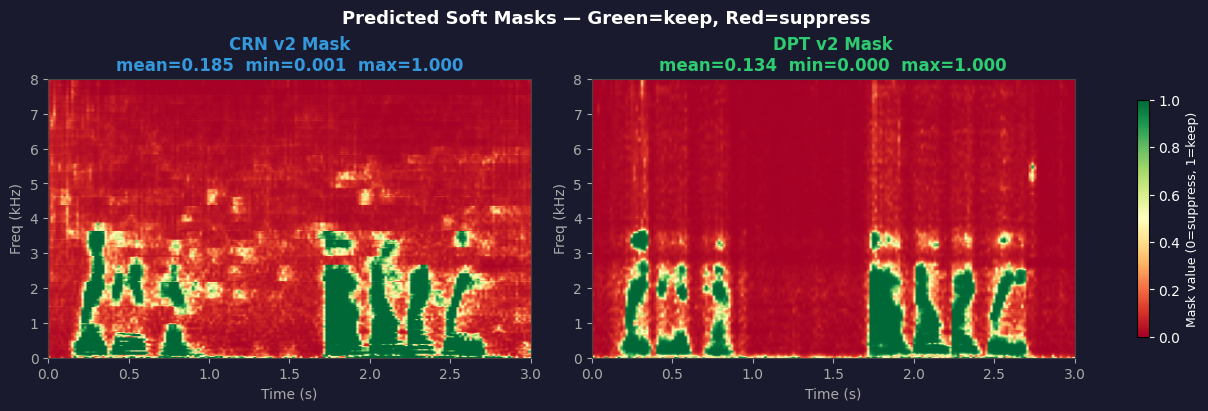

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig.patch.set_facecolor('#1a1a2e')

for ax, (mask, title, color) in zip(axes, [
        (crn_mask, 'CRN v2 Mask', '#3498db'),
        (dpt_mask, 'DPT v2 Mask', '#2ecc71')]):
    im = ax.imshow(mask.numpy(), origin='lower', aspect='auto',
                   cmap='RdYlGn', vmin=0, vmax=1,
                   extent=[0, MAX_LEN/SR, 0, SR/2/1000])
    ax.set_title(f'{title}\nmean={mask.mean():.3f}  min={mask.min():.3f}  max={mask.max():.3f}',
                 fontsize=12, color=color, fontweight='bold')
    ax.set_xlabel('Time (s)', color='#aaa', fontsize=10)
    ax.set_ylabel('Freq (kHz)', color='#aaa', fontsize=10)
    ax.set_facecolor('#16213e')
    ax.tick_params(colors='#aaa')
    for sp in ax.spines.values(): sp.set_edgecolor('#444')

cbar = fig.colorbar(im, ax=axes, shrink=0.85)
cbar.set_label('Mask value (0=suppress, 1=keep)', color='white', fontsize=9)
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')
fig.suptitle('Predicted Soft Masks — Green=keep, Red=suppress', color='white',
             fontsize=13, fontweight='bold')
plt.savefig('inference_masks.png', dpi=150, bbox_inches='tight',
            facecolor=fig.get_facecolor())
plt.show()

## Cell 9 — 🔊 Audio Players
Listen and compare all three outputs directly in the notebook.

In [9]:
def clamp_wav(wav_tensor):
    """Normalise and clamp to [-1, 1] before playback."""
    w = wav_tensor.numpy().astype(np.float32)
    return w / (np.abs(w).max() + 1e-8)

players = [
    ("🔴  Noisy Input",     noisy_wav),
    ("🔵  CRN v2 Enhanced", crn_wav),
    ("🟢  DPT v2 Enhanced", dpt_wav),
]
if clean_wav is not None:
    players.append(("⚪  Clean Target", clean_wav))

for label, wav in players:
    display(HTML(f"<b style='font-size:14px'>{label}</b>"))
    display(Audio(clamp_wav(wav), rate=SR))

## Cell 10 — Metrics Bar Chart
Visual comparison of PESQ, STOI, and SI-SDR across models (only if clean reference is provided).

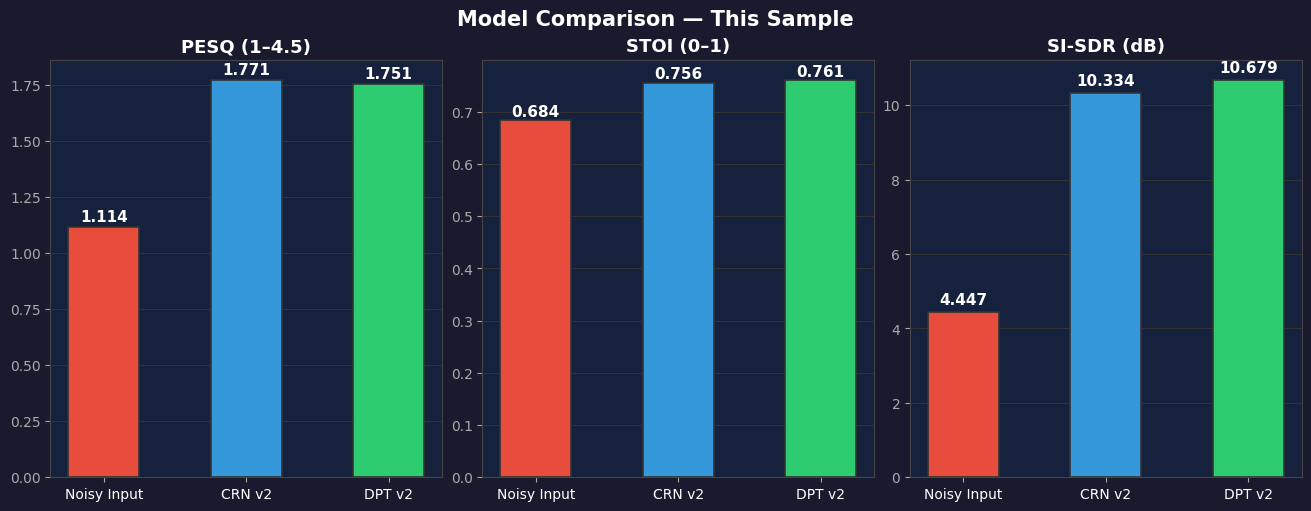


  Improvement over noisy input:
  Metric           CRN Δ       DPT Δ
  ----------------------------------
  PESQ            +0.657      +0.637
  STOI            +0.072      +0.077
  SI-SDR          +5.887dB      +6.232dB


In [10]:
if not (noisy_metrics or crn_metrics or dpt_metrics):
    print("No metrics available (clean reference not provided or pesq/pystoi not installed).")
else:
    metrics_data = {
        'Noisy Input': noisy_metrics,
        'CRN v2':      crn_metrics,
        'DPT v2':      dpt_metrics,
    }
    metric_keys  = ['PESQ', 'STOI', 'SI-SDR']
    bar_colors   = {'Noisy Input': '#e74c3c', 'CRN v2': '#3498db', 'DPT v2': '#2ecc71'}
    units        = {'PESQ': '(1–4.5)', 'STOI': '(0–1)', 'SI-SDR': '(dB)'}

    fig, axes = plt.subplots(1, 3, figsize=(13, 5), constrained_layout=True)
    fig.patch.set_facecolor('#1a1a2e')

    for ax, key in zip(axes, metric_keys):
        models = list(metrics_data.keys())
        vals   = [metrics_data[m].get(key, 0) for m in models]
        colors = [bar_colors[m] for m in models]
        bars   = ax.bar(models, vals, color=colors, width=0.5, edgecolor='#333',
                        linewidth=1.2)
        for bar, val in zip(bars, vals):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02*abs(max(vals)-min(vals)),
                    f'{val:.3f}', ha='center', va='bottom', fontsize=11,
                    color='white', fontweight='bold')
        ax.set_title(f'{key} {units[key]}', color='white', fontsize=13, fontweight='bold')
        ax.set_facecolor('#16213e')
        ax.tick_params(colors='#aaa')
        ax.set_xticklabels(models, color='white', fontsize=10)
        ax.yaxis.set_tick_params(labelcolor='#aaa')
        for sp in ax.spines.values(): sp.set_edgecolor('#444')
        ax.grid(axis='y', color='#333', linewidth=0.7)
        ax.set_axisbelow(True)

    fig.suptitle('Model Comparison — This Sample', color='white',
                 fontsize=15, fontweight='bold')
    plt.savefig('inference_metrics.png', dpi=150, bbox_inches='tight',
                facecolor=fig.get_facecolor())
    plt.show()

    # Delta table
    print("\n  Improvement over noisy input:")
    print(f"  {'Metric':<10}  {'CRN Δ':>10}  {'DPT Δ':>10}")
    print("  " + "-"*34)
    for key in metric_keys:
        n = noisy_metrics.get(key, 0)
        c = crn_metrics.get(key, 0) - n
        d = dpt_metrics.get(key, 0) - n
        unit = 'dB' if key == 'SI-SDR' else ''
        print(f"  {key:<10}  {c:>+10.3f}{unit}  {d:>+10.3f}{unit}")

## Cell 11 — Save Audio Files
Export enhanced WAV files for external playback / submission.

In [11]:
os.makedirs('inference_output', exist_ok=True)

def save_wav(wav_tensor, path, sr=SR):
    w = wav_tensor.numpy().astype(np.float32)
    w = w / (np.abs(w).max() + 1e-8)  # normalise to [-1, 1]
    sf.write(path, w, sr)
    size_kb = os.path.getsize(path) / 1024
    print(f"  Saved: {path}  ({size_kb:.0f} KB)")

save_wav(noisy_wav, 'inference_output/01_noisy.wav')
save_wav(crn_wav,   'inference_output/02_crn_enhanced.wav')
save_wav(dpt_wav,   'inference_output/03_dpt_enhanced.wav')
if clean_wav is not None:
    save_wav(clean_wav, 'inference_output/00_clean_reference.wav')

print("\nAll output files saved to inference_output/")
print("  Play them in order to hear the enhancement progression:"
      "\n  00_clean_reference.wav  ← what the model aims for (if available)"
      "\n  01_noisy.wav            ← degraded input"
      "\n  02_crn_enhanced.wav     ← CRN v2 (1.81M params)"
      "\n  03_dpt_enhanced.wav     ← DPT v2 (0.90M params) — BEST MODEL")


  Saved: inference_output/01_noisy.wav  (94 KB)
  Saved: inference_output/02_crn_enhanced.wav  (94 KB)
  Saved: inference_output/03_dpt_enhanced.wav  (94 KB)
  Saved: inference_output/00_clean_reference.wav  (94 KB)

All output files saved to inference_output/
  Play them in order to hear the enhancement progression:
  00_clean_reference.wav  ← what the model aims for (if available)
  01_noisy.wav            ← degraded input
  02_crn_enhanced.wav     ← CRN v2 (1.81M params)
  03_dpt_enhanced.wav     ← DPT v2 (0.90M params) — BEST MODEL


## Cell 12 — (Optional) Batch Inference on Full Test Set
If you have the test dataset locally, set the directories below to run inference on all 105 test pairs and recompute the full PESQ / STOI / SI-SDR table matching our Kaggle results.

In [12]:
import glob
from tqdm.auto import tqdm

# ── SET THESE to run the full test set ───────────────────────
NOISY_TEST_DIR = None   # e.g. r'D:\data\librispeech-noise\test'
CLEAN_TEST_DIR = None   # e.g. r'D:\data\librispeech-noise\y_test'
# ─────────────────────────────────────────────────────────────

if NOISY_TEST_DIR is None:
    print("Batch mode: set NOISY_TEST_DIR and CLEAN_TEST_DIR above to run.")
else:
    noisy_files = sorted(glob.glob(os.path.join(NOISY_TEST_DIR, '*.wav')))
    clean_files = sorted(glob.glob(os.path.join(CLEAN_TEST_DIR, '*.wav')))
    print(f"Found {len(noisy_files)} test pairs")

    batch_results = {'crn': [], 'dpt': []}

    for nf, cf in tqdm(zip(noisy_files, clean_files), total=len(noisy_files)):
        nwav = load_wav(nf)
        cwav = load_wav(cf)
        n_mag, n_phase, _ = wav_to_stft(nwav)

        crn_w = enhance(crn_model, n_mag, n_phase)[0]
        dpt_w = enhance(dpt_model, n_mag, n_phase)[0]

        batch_results['crn'].append(compute_metrics(cwav, crn_w))
        batch_results['dpt'].append(compute_metrics(cwav, dpt_w))

    for tag in ['crn', 'dpt']:
        rows = batch_results[tag]
        mean = {k: np.mean([r[k] for r in rows if k in r]) for k in ['PESQ', 'STOI', 'SI-SDR']}
        label = 'CRN v2' if tag == 'crn' else 'DPT v2'
        print(f"\n{label}:  PESQ={mean['PESQ']:.3f}  STOI={mean['STOI']:.3f}  SI-SDR={mean['SI-SDR']:.2f}dB")

Batch mode: set NOISY_TEST_DIR and CLEAN_TEST_DIR above to run.
